In [117]:
import warnings
from sklearn.utils import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_auc_score, \
                    matthews_corrcoef, ConfusionMatrixDisplay,f1_score, \
                    accuracy_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset
from torch.nn import Module, Conv1d, Linear, Dropout, MaxPool1d, functional as F, BatchNorm1d, LazyLinear
from torch.optim import Optimizer
from tqdm import tqdm
import os
import pandas as pd
import matplotlib.pyplot as plt

In [118]:
warnings.filterwarnings("ignore", category=Warning)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
if torch.cuda.is_available():
    torch.cuda.empty_cache()

cuda:0


In [119]:
class CustomDataset(Dataset):
    def __init__(self, x, y):
        super(CustomDataset, self).__init__()
        self.data = torch.from_numpy(x).float()
        self.labels = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    def get_labels(self):
        return self.labels

    def get_data(self):
        return self.data


def get_th_dataset(x, y):
    """
    assemble a dataset with the given data and labels
    :param x:
    :param y:
    :return:
    """
    _dataset = CustomDataset(x, y)
    return _dataset


def get_dataloader(dataset: Dataset, batch_size):
    """
    assemble a dataloader with the given dataset
    :param dataset:
    :param batch_size:
    :return:
    """
    _dataLoader = DataLoader(dataset=dataset, batch_size=batch_size, pin_memory=True,
                             drop_last=True, shuffle=True)
    return _dataLoader

In [120]:
class ASLSingleLabel(nn.Module):
    '''
    This loss is intended for single-label classification problems
    '''
    def __init__(self, gamma_pos=0, gamma_neg=4, eps: float = 0.1, reduction='mean'):
        super(ASLSingleLabel, self).__init__()

        self.eps = eps
        self.logsoftmax = nn.LogSoftmax(dim=-1)
        self.targets_classes = []
        self.gamma_pos = gamma_pos
        self.gamma_neg = gamma_neg
        self.reduction = reduction

    def forward(self, inputs, target):
        '''
        "input" dimensions: - (batch_size,number_classes)
        "target" dimensions: - (batch_size)
        '''
        num_classes = inputs.size()[-1]
        log_preds = self.logsoftmax(inputs)
        self.targets_classes = torch.zeros_like(inputs).scatter_(1, target.long().unsqueeze(1), 1)

        # ASL weights
        targets = self.targets_classes
        anti_targets = 1 - targets
        xs_pos = torch.exp(log_preds)
        xs_neg = 1 - xs_pos
        xs_pos = xs_pos * targets
        xs_neg = xs_neg * anti_targets
        asymmetric_w = torch.pow(1 - xs_pos - xs_neg,
                                 self.gamma_pos * targets + self.gamma_neg * anti_targets)
        log_preds = log_preds * asymmetric_w

        if self.eps > 0:  # label smoothing
            self.targets_classes = self.targets_classes.mul(1 - self.eps).add(self.eps / num_classes)

        # loss calculation
        loss = - self.targets_classes.mul(log_preds)

        loss = loss.sum(dim=-1)
        if self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [129]:
class RNN(nn.Module):
    def __init__(self, input_dim=320, hidden_dim=64, output_dim=2, num_layers=1, dropout=0):
        super(RNN, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.device = device
        # LSTM layer
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(device)
        x = x.unsqueeze(1)
        # We need to unsqueeze the input tensor to match the batch_first=True setting
        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))
        # Extract the output of the last time step (many-to-one architecture)
        out = out[:, -1, :].to(device)

        # Pass the output through the fully connected layer
        out = self.fc(out)

        # Apply softmax activation
        out = torch.softmax(out, dim=-1)
        return out

In [130]:
def to_log(epoch: int, loss: float, accuracy, logFile: str, is_append: bool):
    info = str(epoch) + ' ' + str(loss) + ' ' + str(accuracy) + '\n'
    flag = 'a' if is_append else 'w'
    file = open(logFile, flag)  # append mode
    file.write(info)
    file.close()

def scores(y_pred: torch.Tensor, y_test: torch.Tensor):
    predictions = torch.argmax(y_pred, dim=-1).detach().numpy()
    labels = y_test.detach().numpy()
    # labels = th.argmax(y_test, dim=-1).numpy()
    recall = recall_score(y_pred=predictions, y_true=labels, average='binary')
    precision = precision_score(y_pred=predictions, y_true=labels, average='binary')
    f1 = f1_score(y_pred=predictions, y_true=labels, average='binary')
    accuracy = accuracy_score(y_pred=predictions, y_true=labels)
    # auc_score = roc_auc_score(y_score=y_pred.detach().numpy(), y_true=y_test.detach().numpy())
    corr = matthews_corrcoef(y_true=labels, y_pred=predictions)
    balanced_accuracy = balanced_accuracy_score(y_true=labels, y_pred=predictions, )

    report = {
        "recall": recall,
        "precision": precision,
        "f1": f1,
        "accuracy": accuracy,
        # "auc": auc_score,
        'matthews_corrcoef': corr,
        'balanced_accuracy': balanced_accuracy
    }
    return report


def report(model: torch.nn.Module, dataset: CustomDataset):
    _inputs, _labels = dataset.get_data().to(device), dataset.get_labels().to(device)
    print(_inputs.size(0))
    predictions = model(_inputs)
    res = scores(predictions, _labels.squeeze())
    print('accuracy ' + str(res["accuracy"]))
    print('precision ' + str(res["precision"]))
    print('f1 ' + str(res["f1"]))
    print('recall ' + str(res["recall"]))
    # print('auc_score ' + str(res["auc"]))
    print('matthews_corrcoef ' + str(res["matthews_corrcoef"]))
    print('balanced_accuracy ' + str(res["balanced_accuracy"]))
    # get_confusion_matrix(predictions, _labels.squeeze())


def train(model: Module, EPOCHS, optimizer: Optimizer, criteria,
           checkpoint, train_set: DataLoader, vali_set: DataLoader, device, LOG_VALIDATION, LOG_TRAIN):
    """
    fine tune the model and save the best model in the checkpoint
    :param LOG_TRAIN:
    :param LOG_VALIDATION:
    :param device:
    :param model: a Cnn or ConvLSTM model
    :param EPOCHS: hyperparameter Epoch
    :param optimizer: pytorch optimizer
    :param criteria: loss function
    :param checkpoint: model checkpoint
    :param train_set: a dataloader
    :param vali_set: a dataloader
    :return: None
    """
    if os.path.exists(LOG_VALIDATION):
        os.remove(LOG_VALIDATION)
    if os.path.exists(LOG_TRAIN):
        os.remove(LOG_TRAIN)
    model = model.to(device)
    min_vali_loss = float("inf")
    for epoch in tqdm(range(EPOCHS)):
        running_loss = 0.0
        train_acc = []
        vali_loss = 0.0
        model.train()
        counter = 0
        for i, (inputs, labels) in enumerate(train_set):
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            # outputs = outputs.squeeze()
            loss = criteria(outputs.float(), labels.float().squeeze())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            train_acc.append(scores(outputs.to("cpu"), labels.to("cpu"))["accuracy"])
            counter = i
        model.eval()
        acc = 0
        for j, (vali_inputs, vali_labels) in enumerate(vali_set):
            vali_labels = vali_labels.to(device)
            vali_inputs = vali_inputs.to(device)
            vali_outputs = model(vali_inputs)
            # vali_outputs = vali_outputs.squeeze()
            acc = scores(vali_outputs.to('cpu'), vali_labels.to('cpu'))["accuracy"]
            vali_loss = criteria(vali_outputs.to(device).float(), vali_labels.to(device).float().squeeze())
            if vali_loss < min_vali_loss:
                min_vali_loss = vali_loss
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                }, checkpoint)
        avg_loss = running_loss / counter  # loss per batch
        train_accuracy = sum(train_acc) / len(train_acc)
        print('epoch {} train_loss: {} vali_loss: {} test_acc: {}'
              .format(epoch + 1, f'{avg_loss:5f}', f'{vali_loss:5f}', f'{acc: 5f}'))
        # logs
        to_log(epoch, avg_loss, train_accuracy, LOG_TRAIN, True)
        to_log(epoch, vali_loss.item(), acc, LOG_VALIDATION, True)

In [131]:
checkpoint = os.path.join(os.getcwd(), 'rnn.pt')
train_loss_log = os.path.join(os.getcwd(), "rnn_train_log.txt")
test_loss_log = os.path.join(os.getcwd(), "rnn_validation_log.txt")

plot_range = 10000  # range(1, 10000)
stratify = True
batch_size = 16
lr = 0.0001
epochs = 100
weight_decay = 0

df = pd.read_csv('../data/drugfinder/esm2_320_dimensions_with_labels.csv') 
X = df.drop(['label', 'UniProt_id'], axis=1)
y = df['label'].apply(lambda x: 0 if x != 1 else x).to_numpy().astype(np.int64)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scalar = MinMaxScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.fit_transform(X_test)
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
train_loader = get_dataloader(train_set, batch_size=batch_size)
test_loader = get_dataloader(test_set, batch_size=len(test_set))

In [132]:
model = RNN()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
criteria = ASLSingleLabel(gamma_pos=1, gamma_neg=1, eps = 0.1)  # find the best hyperparameter

In [133]:
train(model=model, EPOCHS=epochs, optimizer=optimizer, checkpoint=checkpoint, criteria=criteria,
      train_set=train_loader, vali_set=test_loader, device=device, LOG_VALIDATION=test_loss_log, LOG_TRAIN=train_loss_log)

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [00:00<00:39,  2.51it/s]

epoch 1 train_loss: 0.346381 vali_loss: 0.337254 test_acc:  0.513043


  2%|▏         | 2/100 [00:00<00:38,  2.53it/s]

epoch 2 train_loss: 0.330629 vali_loss: 0.314834 test_acc:  0.621739


  3%|▎         | 3/100 [00:01<00:38,  2.54it/s]

epoch 3 train_loss: 0.307514 vali_loss: 0.282332 test_acc:  0.810870


  4%|▍         | 4/100 [00:01<00:37,  2.56it/s]

epoch 4 train_loss: 0.283161 vali_loss: 0.254840 test_acc:  0.865217


  5%|▌         | 5/100 [00:02<00:38,  2.44it/s]

epoch 5 train_loss: 0.264406 vali_loss: 0.235810 test_acc:  0.867391


  6%|▌         | 6/100 [00:02<00:38,  2.46it/s]

epoch 6 train_loss: 0.251014 vali_loss: 0.222917 test_acc:  0.884783


  7%|▋         | 7/100 [00:02<00:37,  2.50it/s]

epoch 7 train_loss: 0.240945 vali_loss: 0.214107 test_acc:  0.882609


  8%|▊         | 8/100 [00:03<00:36,  2.51it/s]

epoch 8 train_loss: 0.234031 vali_loss: 0.206351 test_acc:  0.897826


  9%|▉         | 9/100 [00:03<00:35,  2.55it/s]

epoch 9 train_loss: 0.229612 vali_loss: 0.200827 test_acc:  0.895652


 10%|█         | 10/100 [00:03<00:34,  2.57it/s]

epoch 10 train_loss: 0.223471 vali_loss: 0.196635 test_acc:  0.897826


 11%|█         | 11/100 [00:04<00:34,  2.58it/s]

epoch 11 train_loss: 0.219005 vali_loss: 0.193279 test_acc:  0.889130


 12%|█▏        | 12/100 [00:04<00:34,  2.58it/s]

epoch 12 train_loss: 0.217220 vali_loss: 0.189295 test_acc:  0.902174


 13%|█▎        | 13/100 [00:05<00:34,  2.56it/s]

epoch 13 train_loss: 0.214314 vali_loss: 0.188153 test_acc:  0.900000


 14%|█▍        | 14/100 [00:05<00:33,  2.57it/s]

epoch 14 train_loss: 0.212407 vali_loss: 0.187832 test_acc:  0.893478


 15%|█▌        | 15/100 [00:05<00:33,  2.52it/s]

epoch 15 train_loss: 0.209186 vali_loss: 0.182458 test_acc:  0.908696


 16%|█▌        | 16/100 [00:06<00:32,  2.55it/s]

epoch 16 train_loss: 0.207529 vali_loss: 0.180473 test_acc:  0.904348


 17%|█▋        | 17/100 [00:06<00:32,  2.53it/s]

epoch 17 train_loss: 0.205538 vali_loss: 0.179119 test_acc:  0.910870


 18%|█▊        | 18/100 [00:07<00:32,  2.50it/s]

epoch 18 train_loss: 0.203569 vali_loss: 0.176246 test_acc:  0.915217


 19%|█▉        | 19/100 [00:07<00:32,  2.50it/s]

epoch 19 train_loss: 0.201539 vali_loss: 0.175908 test_acc:  0.913043


 20%|██        | 20/100 [00:07<00:32,  2.47it/s]

epoch 20 train_loss: 0.200094 vali_loss: 0.175445 test_acc:  0.913043


 21%|██        | 21/100 [00:08<00:31,  2.48it/s]

epoch 21 train_loss: 0.200219 vali_loss: 0.173183 test_acc:  0.913043


 22%|██▏       | 22/100 [00:08<00:32,  2.40it/s]

epoch 22 train_loss: 0.197881 vali_loss: 0.171987 test_acc:  0.913043


 23%|██▎       | 23/100 [00:09<00:32,  2.40it/s]

epoch 23 train_loss: 0.195854 vali_loss: 0.170056 test_acc:  0.915217


 24%|██▍       | 24/100 [00:09<00:31,  2.45it/s]

epoch 24 train_loss: 0.195568 vali_loss: 0.172064 test_acc:  0.915217


 25%|██▌       | 25/100 [00:09<00:30,  2.46it/s]

epoch 25 train_loss: 0.195173 vali_loss: 0.167837 test_acc:  0.917391


 26%|██▌       | 26/100 [00:10<00:29,  2.47it/s]

epoch 26 train_loss: 0.193486 vali_loss: 0.167210 test_acc:  0.919565


 27%|██▋       | 27/100 [00:10<00:29,  2.48it/s]

epoch 27 train_loss: 0.190908 vali_loss: 0.166423 test_acc:  0.919565


 28%|██▊       | 28/100 [00:11<00:28,  2.48it/s]

epoch 28 train_loss: 0.190514 vali_loss: 0.165791 test_acc:  0.921739


 29%|██▉       | 29/100 [00:11<00:28,  2.45it/s]

epoch 29 train_loss: 0.190306 vali_loss: 0.170073 test_acc:  0.910870


 30%|███       | 30/100 [00:11<00:28,  2.50it/s]

epoch 30 train_loss: 0.188785 vali_loss: 0.164193 test_acc:  0.926087


 31%|███       | 31/100 [00:12<00:27,  2.53it/s]

epoch 31 train_loss: 0.187121 vali_loss: 0.166757 test_acc:  0.915217


 32%|███▏      | 32/100 [00:12<00:27,  2.49it/s]

epoch 32 train_loss: 0.185745 vali_loss: 0.164116 test_acc:  0.919565


 33%|███▎      | 33/100 [00:13<00:26,  2.50it/s]

epoch 33 train_loss: 0.185315 vali_loss: 0.166181 test_acc:  0.915217


 34%|███▍      | 34/100 [00:13<00:26,  2.46it/s]

epoch 34 train_loss: 0.184714 vali_loss: 0.162494 test_acc:  0.921739


 35%|███▌      | 35/100 [00:14<00:26,  2.45it/s]

epoch 35 train_loss: 0.184067 vali_loss: 0.169120 test_acc:  0.910870


 36%|███▌      | 36/100 [00:14<00:25,  2.49it/s]

epoch 36 train_loss: 0.184903 vali_loss: 0.162534 test_acc:  0.919565


 37%|███▋      | 37/100 [00:14<00:24,  2.53it/s]

epoch 37 train_loss: 0.183637 vali_loss: 0.163316 test_acc:  0.910870


 38%|███▊      | 38/100 [00:15<00:24,  2.57it/s]

epoch 38 train_loss: 0.183764 vali_loss: 0.160522 test_acc:  0.928261


 39%|███▉      | 39/100 [00:15<00:23,  2.61it/s]

epoch 39 train_loss: 0.182563 vali_loss: 0.160111 test_acc:  0.930435


 40%|████      | 40/100 [00:15<00:23,  2.60it/s]

epoch 40 train_loss: 0.182186 vali_loss: 0.160166 test_acc:  0.928261


 41%|████      | 41/100 [00:16<00:22,  2.65it/s]

epoch 41 train_loss: 0.180723 vali_loss: 0.159592 test_acc:  0.930435


 42%|████▏     | 42/100 [00:16<00:22,  2.58it/s]

epoch 42 train_loss: 0.180718 vali_loss: 0.159257 test_acc:  0.932609


 43%|████▎     | 43/100 [00:17<00:22,  2.58it/s]

epoch 43 train_loss: 0.180276 vali_loss: 0.162943 test_acc:  0.913043


 44%|████▍     | 44/100 [00:17<00:21,  2.59it/s]

epoch 44 train_loss: 0.178707 vali_loss: 0.158836 test_acc:  0.928261


 45%|████▌     | 45/100 [00:17<00:21,  2.61it/s]

epoch 45 train_loss: 0.179014 vali_loss: 0.160943 test_acc:  0.921739


 46%|████▌     | 46/100 [00:18<00:20,  2.63it/s]

epoch 46 train_loss: 0.177995 vali_loss: 0.160169 test_acc:  0.923913


 47%|████▋     | 47/100 [00:18<00:20,  2.61it/s]

epoch 47 train_loss: 0.177692 vali_loss: 0.160556 test_acc:  0.919565


 48%|████▊     | 48/100 [00:18<00:19,  2.60it/s]

epoch 48 train_loss: 0.176872 vali_loss: 0.157657 test_acc:  0.932609


 49%|████▉     | 49/100 [00:19<00:19,  2.62it/s]

epoch 49 train_loss: 0.176304 vali_loss: 0.159850 test_acc:  0.921739


 50%|█████     | 50/100 [00:19<00:19,  2.62it/s]

epoch 50 train_loss: 0.176710 vali_loss: 0.158043 test_acc:  0.928261


 51%|█████     | 51/100 [00:20<00:19,  2.56it/s]

epoch 51 train_loss: 0.174989 vali_loss: 0.158244 test_acc:  0.928261


 52%|█████▏    | 52/100 [00:20<00:18,  2.59it/s]

epoch 52 train_loss: 0.176183 vali_loss: 0.157312 test_acc:  0.930435


 53%|█████▎    | 53/100 [00:20<00:18,  2.57it/s]

epoch 53 train_loss: 0.175106 vali_loss: 0.157181 test_acc:  0.930435


 54%|█████▍    | 54/100 [00:21<00:17,  2.56it/s]

epoch 54 train_loss: 0.174015 vali_loss: 0.156814 test_acc:  0.930435


 55%|█████▌    | 55/100 [00:21<00:17,  2.54it/s]

epoch 55 train_loss: 0.175139 vali_loss: 0.156565 test_acc:  0.930435


 56%|█████▌    | 56/100 [00:22<00:17,  2.55it/s]

epoch 56 train_loss: 0.173814 vali_loss: 0.156696 test_acc:  0.928261


 57%|█████▋    | 57/100 [00:22<00:16,  2.55it/s]

epoch 57 train_loss: 0.173252 vali_loss: 0.156137 test_acc:  0.930435


 58%|█████▊    | 58/100 [00:22<00:16,  2.56it/s]

epoch 58 train_loss: 0.174174 vali_loss: 0.157819 test_acc:  0.919565


 59%|█████▉    | 59/100 [00:23<00:16,  2.49it/s]

epoch 59 train_loss: 0.173495 vali_loss: 0.155898 test_acc:  0.932609


 60%|██████    | 60/100 [00:23<00:16,  2.47it/s]

epoch 60 train_loss: 0.172759 vali_loss: 0.159478 test_acc:  0.915217


 61%|██████    | 61/100 [00:24<00:15,  2.50it/s]

epoch 61 train_loss: 0.172221 vali_loss: 0.158811 test_acc:  0.915217


 62%|██████▏   | 62/100 [00:24<00:15,  2.51it/s]

epoch 62 train_loss: 0.173810 vali_loss: 0.155909 test_acc:  0.926087


 63%|██████▎   | 63/100 [00:24<00:14,  2.53it/s]

epoch 63 train_loss: 0.172374 vali_loss: 0.155884 test_acc:  0.923913


 64%|██████▍   | 64/100 [00:25<00:14,  2.52it/s]

epoch 64 train_loss: 0.172828 vali_loss: 0.155348 test_acc:  0.932609


 65%|██████▌   | 65/100 [00:25<00:14,  2.49it/s]

epoch 65 train_loss: 0.172115 vali_loss: 0.155729 test_acc:  0.930435


 66%|██████▌   | 66/100 [00:26<00:13,  2.51it/s]

epoch 66 train_loss: 0.171672 vali_loss: 0.157509 test_acc:  0.917391


 67%|██████▋   | 67/100 [00:26<00:13,  2.53it/s]

epoch 67 train_loss: 0.171249 vali_loss: 0.158889 test_acc:  0.917391


 68%|██████▊   | 68/100 [00:26<00:12,  2.54it/s]

epoch 68 train_loss: 0.171700 vali_loss: 0.156396 test_acc:  0.917391


 69%|██████▉   | 69/100 [00:27<00:12,  2.56it/s]

epoch 69 train_loss: 0.170706 vali_loss: 0.154877 test_acc:  0.930435


 70%|███████   | 70/100 [00:27<00:11,  2.58it/s]

epoch 70 train_loss: 0.170503 vali_loss: 0.154752 test_acc:  0.932609


 71%|███████   | 71/100 [00:28<00:11,  2.57it/s]

epoch 71 train_loss: 0.170969 vali_loss: 0.154626 test_acc:  0.932609


 72%|███████▏  | 72/100 [00:28<00:10,  2.56it/s]

epoch 72 train_loss: 0.170897 vali_loss: 0.161899 test_acc:  0.913043


 73%|███████▎  | 73/100 [00:28<00:10,  2.50it/s]

epoch 73 train_loss: 0.169940 vali_loss: 0.155978 test_acc:  0.921739


 74%|███████▍  | 74/100 [00:29<00:10,  2.49it/s]

epoch 74 train_loss: 0.171781 vali_loss: 0.162262 test_acc:  0.913043


 75%|███████▌  | 75/100 [00:29<00:09,  2.52it/s]

epoch 75 train_loss: 0.169625 vali_loss: 0.155258 test_acc:  0.926087


 76%|███████▌  | 76/100 [00:30<00:09,  2.51it/s]

epoch 76 train_loss: 0.168227 vali_loss: 0.154479 test_acc:  0.923913


 77%|███████▋  | 77/100 [00:30<00:09,  2.52it/s]

epoch 77 train_loss: 0.167871 vali_loss: 0.154305 test_acc:  0.926087


 78%|███████▊  | 78/100 [00:30<00:08,  2.57it/s]

epoch 78 train_loss: 0.171608 vali_loss: 0.155354 test_acc:  0.921739


 79%|███████▉  | 79/100 [00:31<00:08,  2.59it/s]

epoch 79 train_loss: 0.168883 vali_loss: 0.155512 test_acc:  0.923913


 80%|████████  | 80/100 [00:31<00:07,  2.53it/s]

epoch 80 train_loss: 0.168626 vali_loss: 0.156038 test_acc:  0.923913


 81%|████████  | 81/100 [00:32<00:07,  2.53it/s]

epoch 81 train_loss: 0.169028 vali_loss: 0.158162 test_acc:  0.919565


 82%|████████▏ | 82/100 [00:32<00:07,  2.54it/s]

epoch 82 train_loss: 0.168779 vali_loss: 0.154136 test_acc:  0.923913


 83%|████████▎ | 83/100 [00:32<00:06,  2.56it/s]

epoch 83 train_loss: 0.169454 vali_loss: 0.159602 test_acc:  0.919565


 84%|████████▍ | 84/100 [00:33<00:06,  2.56it/s]

epoch 84 train_loss: 0.169917 vali_loss: 0.155537 test_acc:  0.923913


 85%|████████▌ | 85/100 [00:33<00:05,  2.59it/s]

epoch 85 train_loss: 0.167252 vali_loss: 0.154396 test_acc:  0.923913


 86%|████████▌ | 86/100 [00:33<00:05,  2.63it/s]

epoch 86 train_loss: 0.167490 vali_loss: 0.159717 test_acc:  0.919565


 87%|████████▋ | 87/100 [00:34<00:04,  2.62it/s]

epoch 87 train_loss: 0.167200 vali_loss: 0.153736 test_acc:  0.923913


 88%|████████▊ | 88/100 [00:34<00:04,  2.59it/s]

epoch 88 train_loss: 0.167167 vali_loss: 0.157418 test_acc:  0.919565


 89%|████████▉ | 89/100 [00:35<00:04,  2.51it/s]

epoch 89 train_loss: 0.167398 vali_loss: 0.159665 test_acc:  0.919565


 90%|█████████ | 90/100 [00:35<00:03,  2.53it/s]

epoch 90 train_loss: 0.167780 vali_loss: 0.155489 test_acc:  0.928261


 91%|█████████ | 91/100 [00:35<00:03,  2.54it/s]

epoch 91 train_loss: 0.167254 vali_loss: 0.153866 test_acc:  0.926087


 92%|█████████▏| 92/100 [00:36<00:03,  2.56it/s]

epoch 92 train_loss: 0.165479 vali_loss: 0.153894 test_acc:  0.921739


 93%|█████████▎| 93/100 [00:36<00:02,  2.53it/s]

epoch 93 train_loss: 0.165134 vali_loss: 0.154809 test_acc:  0.921739


 94%|█████████▍| 94/100 [00:37<00:02,  2.54it/s]

epoch 94 train_loss: 0.165805 vali_loss: 0.156257 test_acc:  0.917391


 95%|█████████▌| 95/100 [00:37<00:01,  2.58it/s]

epoch 95 train_loss: 0.166044 vali_loss: 0.153674 test_acc:  0.926087


 96%|█████████▌| 96/100 [00:37<00:01,  2.58it/s]

epoch 96 train_loss: 0.166181 vali_loss: 0.154138 test_acc:  0.921739


 97%|█████████▋| 97/100 [00:38<00:01,  2.60it/s]

epoch 97 train_loss: 0.166345 vali_loss: 0.156603 test_acc:  0.921739


 98%|█████████▊| 98/100 [00:38<00:00,  2.55it/s]

epoch 98 train_loss: 0.167257 vali_loss: 0.161796 test_acc:  0.917391


 99%|█████████▉| 99/100 [00:39<00:00,  2.58it/s]

epoch 99 train_loss: 0.165521 vali_loss: 0.153690 test_acc:  0.919565


100%|██████████| 100/100 [00:39<00:00,  2.54it/s]

epoch 100 train_loss: 0.164258 vali_loss: 0.153895 test_acc:  0.921739


In [155]:
device = 'cpu'
checkpoint = os.path.join(os.getcwd(), 'rnn.pt')
checkpoint = torch.load(checkpoint, map_location='cpu')
saved_model = RNN()
saved_model.load_state_dict(checkpoint['model_state_dict'])
saved_model.eval()

RNN(
  (lstm): LSTM(320, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

In [156]:
train_set = get_th_dataset(X_train, y_train)
test_set = get_th_dataset(X_test, y_test)
print('train set val')
report(saved_model, train_set)
print('test set val')
report(saved_model, test_set)

train set val
1838
accuracy 0.9183895538628944
precision 0.9231707317073171
f1 0.9098557692307692
recall 0.8969194312796208
matthews_corrcoef 0.8356214948001467
balanced_accuracy 0.91676957479474
test set val
460
accuracy 0.9260869565217391
precision 0.9094827586206896
f1 0.9254385964912281
recall 0.9419642857142857
matthews_corrcoef 0.8527231857806425
balanced_accuracy 0.926490617433414


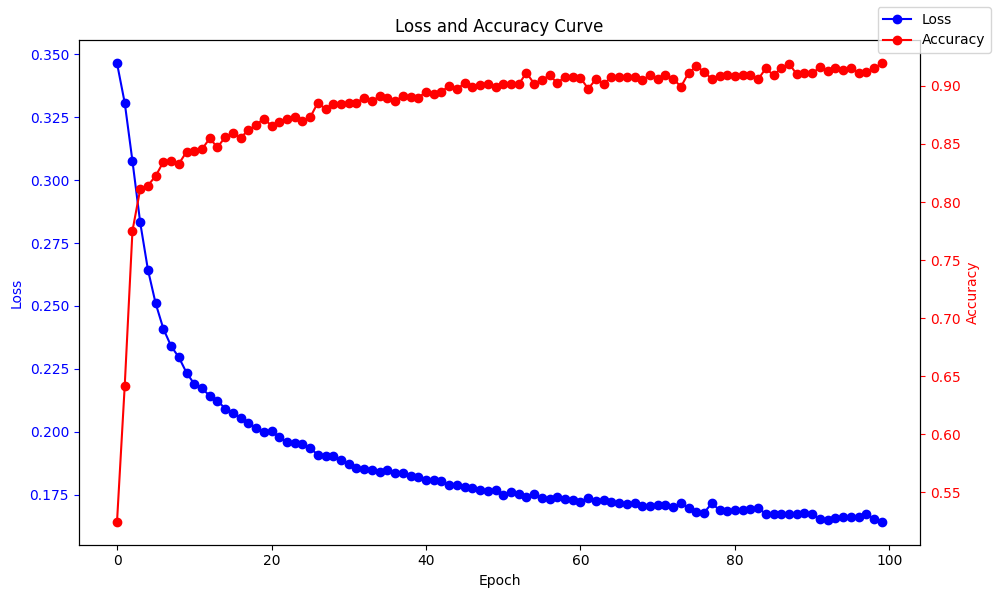

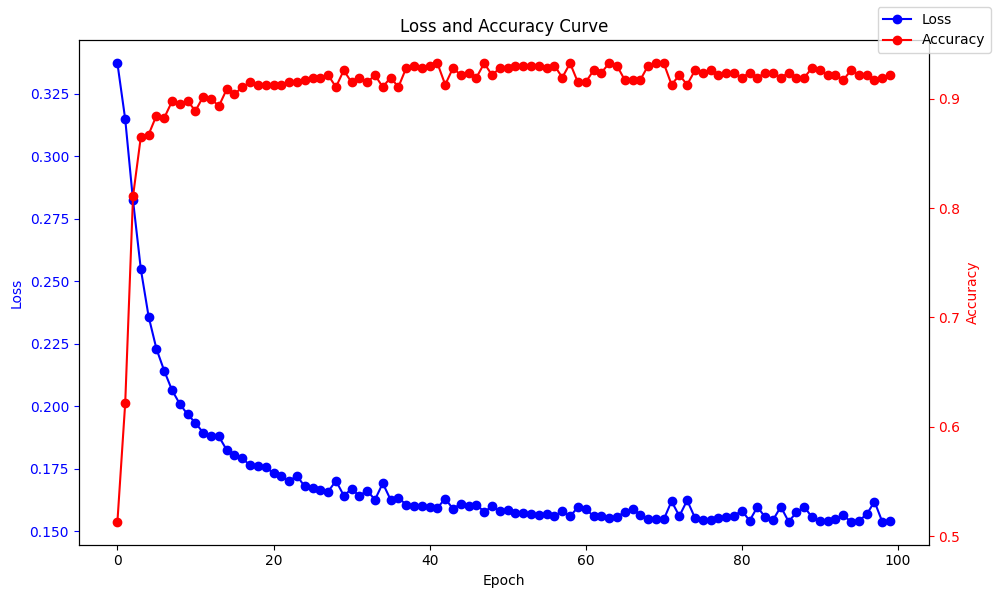

In [157]:
def plot_loss_acc_curve(filename):
    epochs, losses, accs = [], [], []

    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split()
            epoch, loss, acc = int(parts[0]), float(parts[1]), float(parts[2])
            epochs.append(epoch)
            losses.append(loss)
            accs.append(acc)

    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot Loss on the left y-axis
    ax1.plot(epochs, losses, marker='o', linestyle='-', color='b', label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax1.tick_params('y', colors='b')
    
    # Create a second y-axis for accuracy
    ax2 = ax1.twinx()
    ax2.plot(epochs, accs, marker='o', linestyle='-', color='r', label='Accuracy')
    ax2.set_ylabel('Accuracy', color='r')
    ax2.tick_params('y', colors='r')

    plt.title('Loss and Accuracy Curve')
    fig.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Usage
plot_loss_acc_curve('rnn_train_log.txt')

#because of mini batch reasons, the validation plot is not smooth
plot_loss_acc_curve('rnn_validation_log.txt')